In [2]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [12]:
df = pd.read_csv('datasets/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [13]:
df.shape

(145460, 23)

Удалим столбцы

In [14]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [15]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [16]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

C:\Users\mimim\AppData\Local\Temp\ipykernel_25092\3734455367.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
C:\Users\mimim\AppData\Local\Temp\ipykernel_25092\3734455367.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday

In [17]:
df[df['RainTomorrow']==0.0].count()

Rainfall        97103
Humidity3pm     97103
Pressure9am     97103
RainToday       97103
RainTomorrow    97103
dtype: int64

In [18]:
df[df['RainTomorrow']==1.0].count()

Rainfall        27586
Humidity3pm     27586
Pressure9am     27586
RainToday       27586
RainTomorrow    27586
dtype: int64

Классы несбалансированы

In [19]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [20]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [21]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [22]:
criterion = nn.BCELoss()

In [23]:
device = torch.device( "cpu")

In [24]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [25]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [27]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
        
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 100
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 200
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 300
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 400
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 500
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 600
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 700
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 800
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 900
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 1000
    Test  set - loss: 21.062036514282227, accuracy: 0.7784505486488342
    
epoch 1100
    Test  set - loss: 21.062036514282227, ac

In [28]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [29]:
net = torch.load(MODEL_PATH)

C:\Users\mimim\AppData\Local\Temp\ipykernel_25092\804352145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [20]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



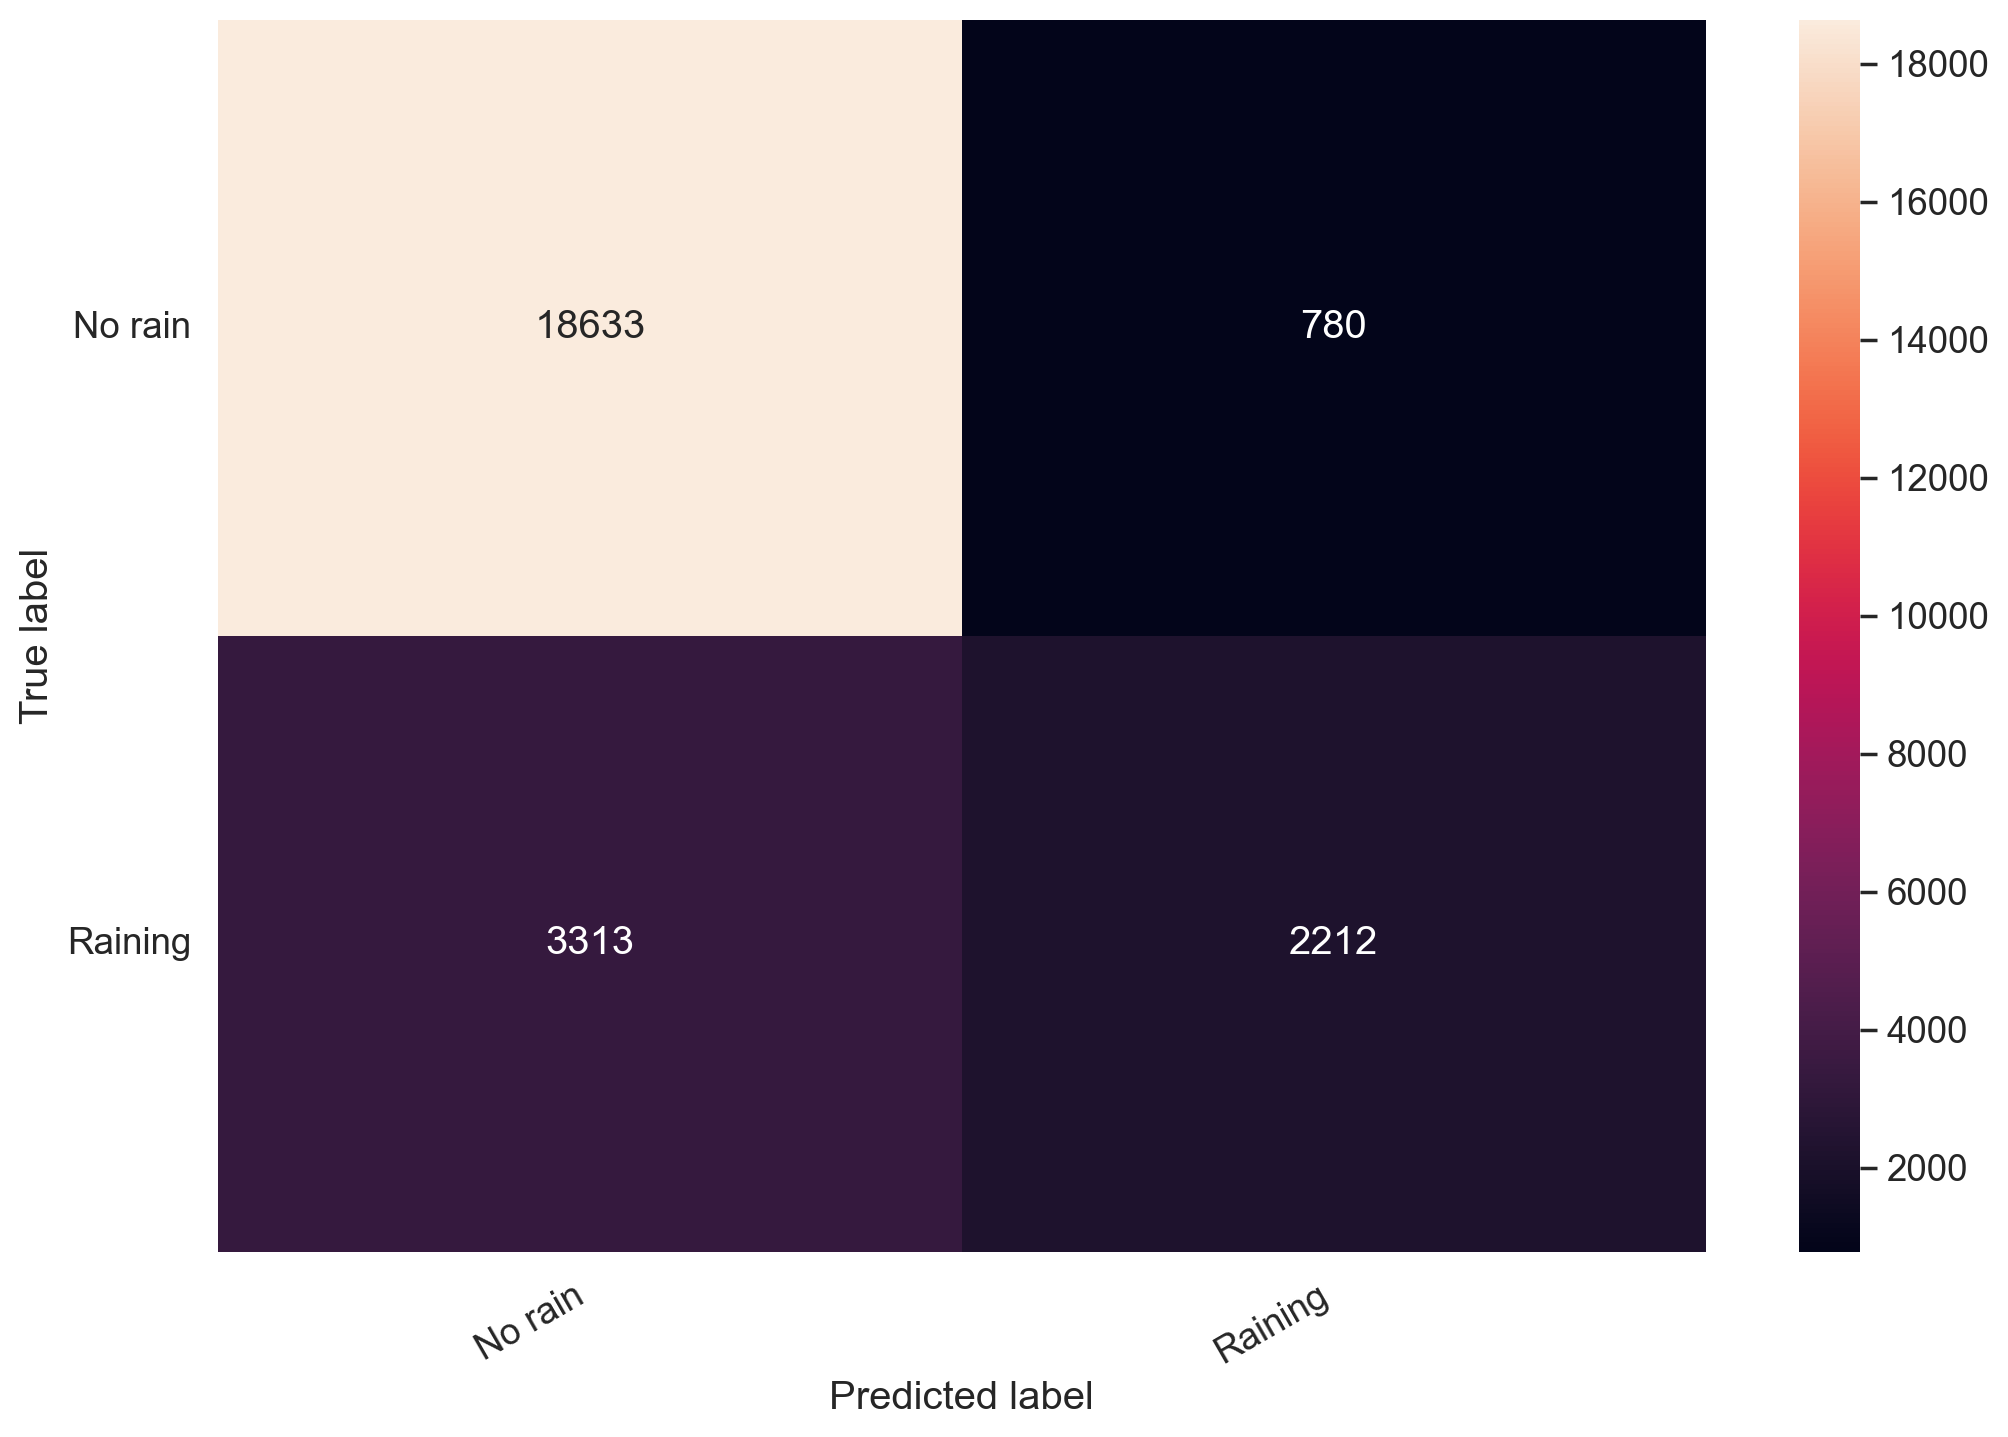

In [21]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

Обучение с lr: 0.0001
Epoch 0: Train Loss = 0.7393, Test Loss = 0.7387, Train Acc = 0.2847, Test Acc = 0.2848
Epoch 100: Train Loss = 0.7194, Test Loss = 0.7188, Train Acc = 0.3625, Test Acc = 0.3682
Epoch 200: Train Loss = 0.6979, Test Loss = 0.6973, Train Acc = 0.4696, Test Acc = 0.4722
Epoch 300: Train Loss = 0.6750, Test Loss = 0.6742, Train Acc = 0.5663, Test Acc = 0.5693
Epoch 400: Train Loss = 0.6511, Test Loss = 0.6502, Train Acc = 0.6376, Test Acc = 0.6407
Epoch 500: Train Loss = 0.6270, Test Loss = 0.6260, Train Acc = 0.6899, Test Acc = 0.6891
Epoch 600: Train Loss = 0.6029, Test Loss = 0.6018, Train Acc = 0.7335, Test Acc = 0.7339
Epoch 700: Train Loss = 0.5797, Test Loss = 0.5785, Train Acc = 0.7571, Test Acc = 0.7616
Epoch 800: Train Loss = 0.5585, Test Loss = 0.5572, Train Acc = 0.7633, Test Acc = 0.7681
Epoch 900: Train Loss = 0.5396, Test Loss = 0.5382, Train Acc = 0.7641, Test Acc = 0.7689
Epoch 1000: Train Loss = 0.5226, Test Loss = 0.5212, Train Acc = 0.7653, Test Ac

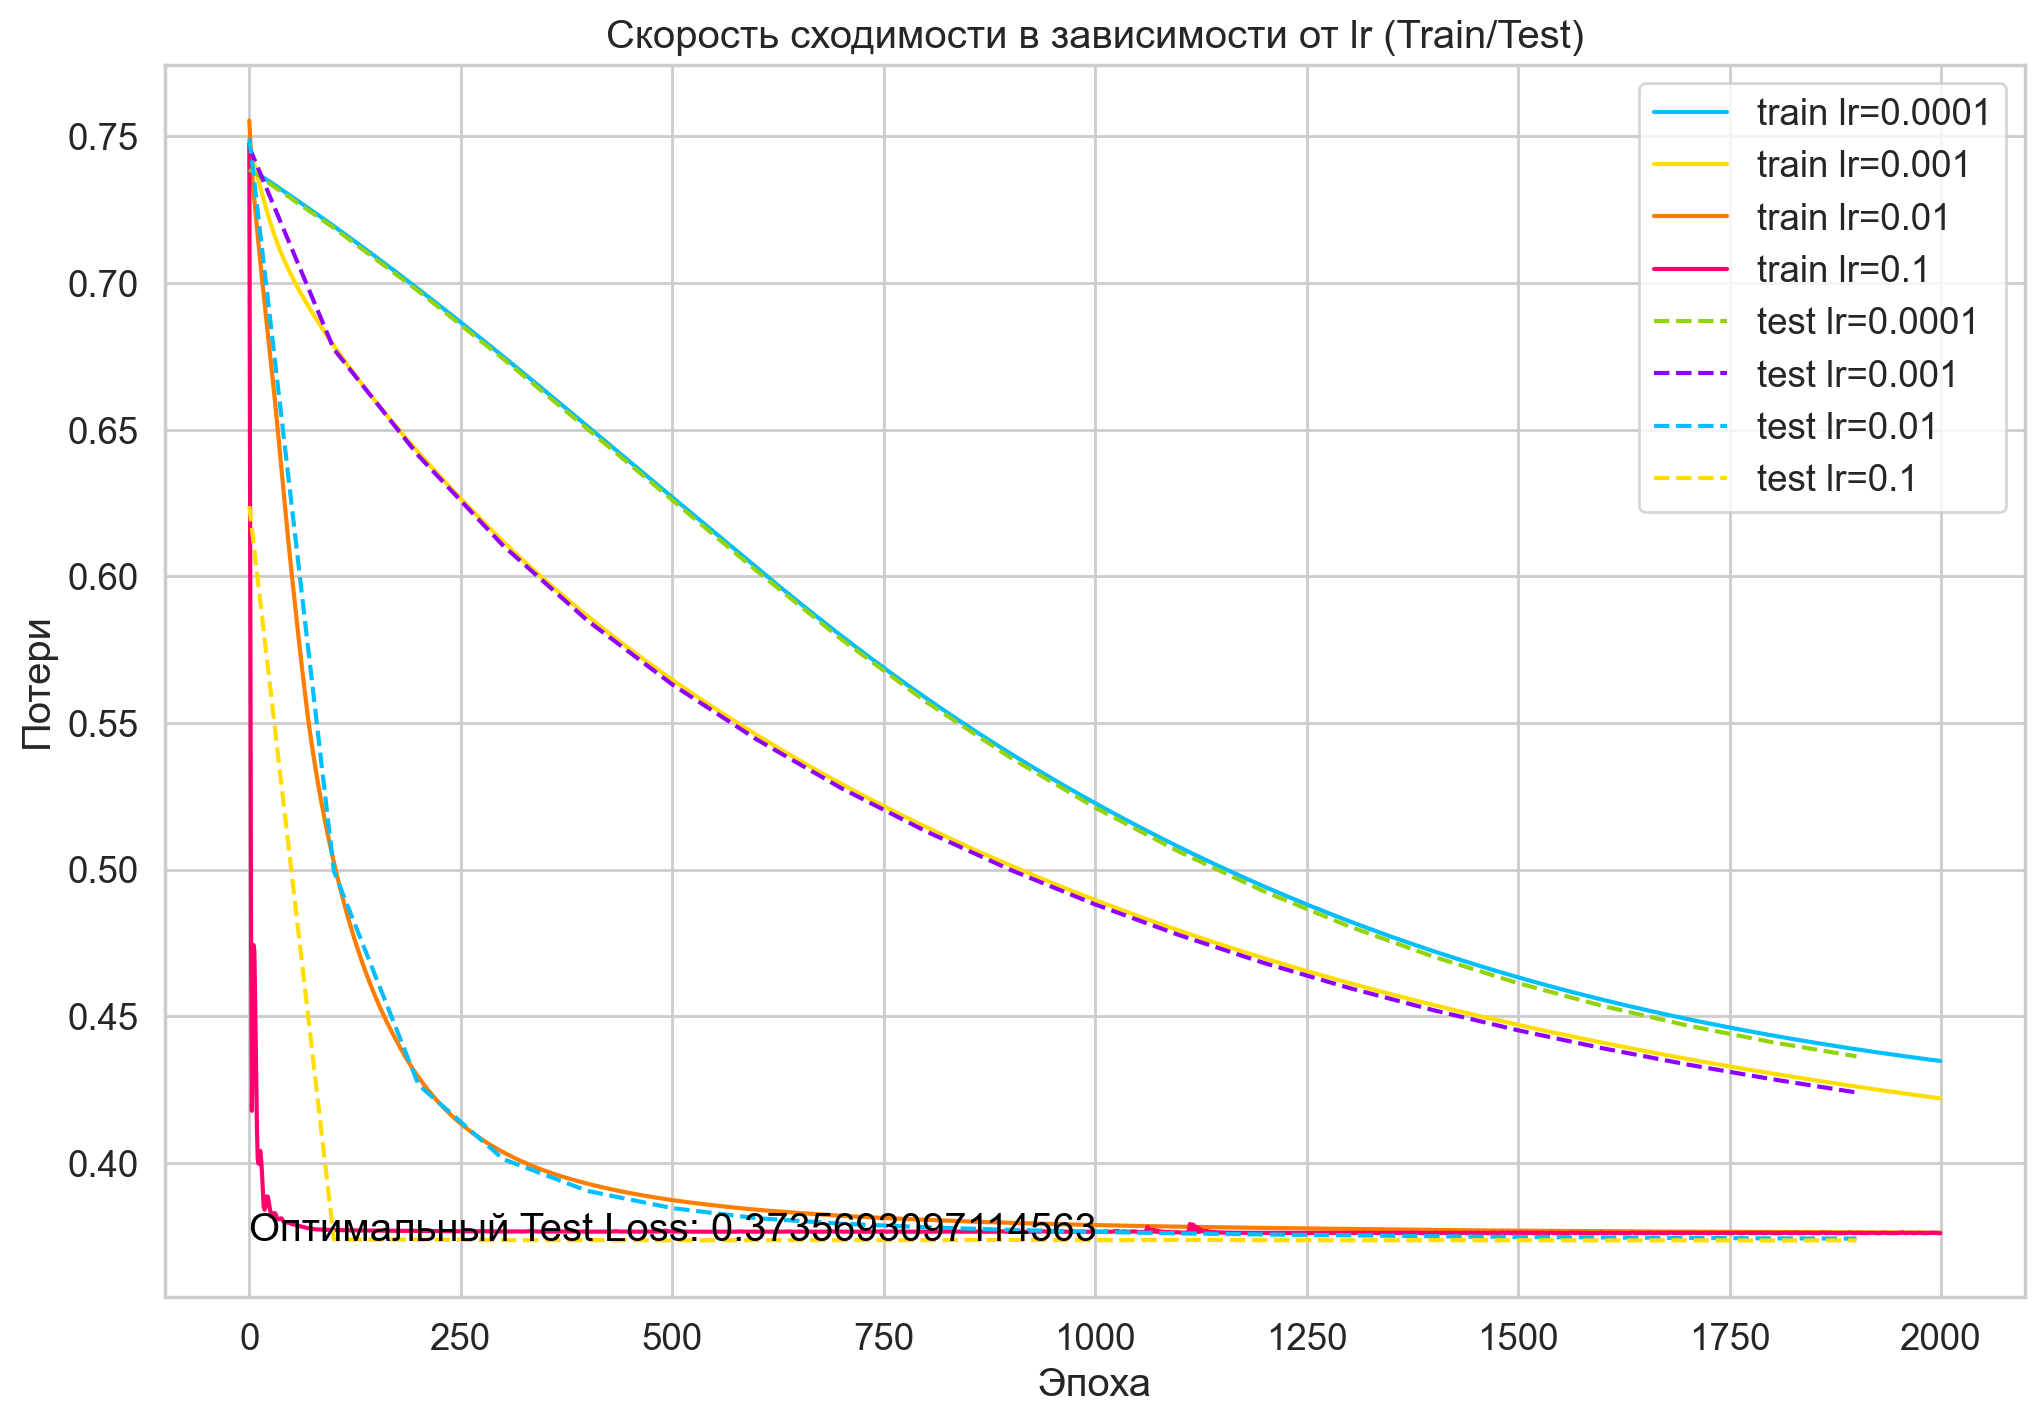

In [44]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate
# выберите оптимальное значение.
def compute_accuracy(y_true, y_pred):
    y_pred_rounded = torch.round(y_pred)
    correct = (y_pred_rounded == y_true).float().sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy

def train_and_evaluate(learning_rate):
    net = Net(4)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())

        train_loss.backward()

        optimizer.step()

        train_losses.append(train_loss.item())

        train_accuracy = compute_accuracy(y_train, y_pred)

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())
            test_accuracy = compute_accuracy(y_test, y_test_pred)
            print(f"Epoch {epoch}: Train Loss = {train_loss.item():.4f}, Test Loss = {test_loss.item():.4f}, Train Acc = {train_accuracy:.4f}, Test Acc = {test_accuracy:.4f}")


    return train_losses, test_losses

learning_rates = [0.0001, 0.001, 0.01, 0.1]
device = torch.device("cpu")
train_loss = {}
test_loss = {}
test_loss_sum = {}

# Процесс обучения для каждого learning_rate
for lr in learning_rates:
    print(f'Обучение с lr: {lr}')
    train_losses, test_losses = train_and_evaluate(lr)
    train_loss[lr] = train_losses
    test_loss[lr] = test_losses
    test_loss_sum[lr] = test_losses[-1]

optimal_lr = min(test_loss_sum, key=test_loss_sum.get)
print(f'Оптимальный lr: {optimal_lr}')

for lr, losses in train_loss.items():
    plt.plot(losses, label=f'train lr={lr}')

for lr, losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'test lr={lr}', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости в зависимости от lr (Train/Test)')
plt.text(0, test_loss_sum[optimal_lr], f'Оптимальный Test Loss: {test_loss_sum[optimal_lr]}', color='black')
plt.legend()
plt.show()

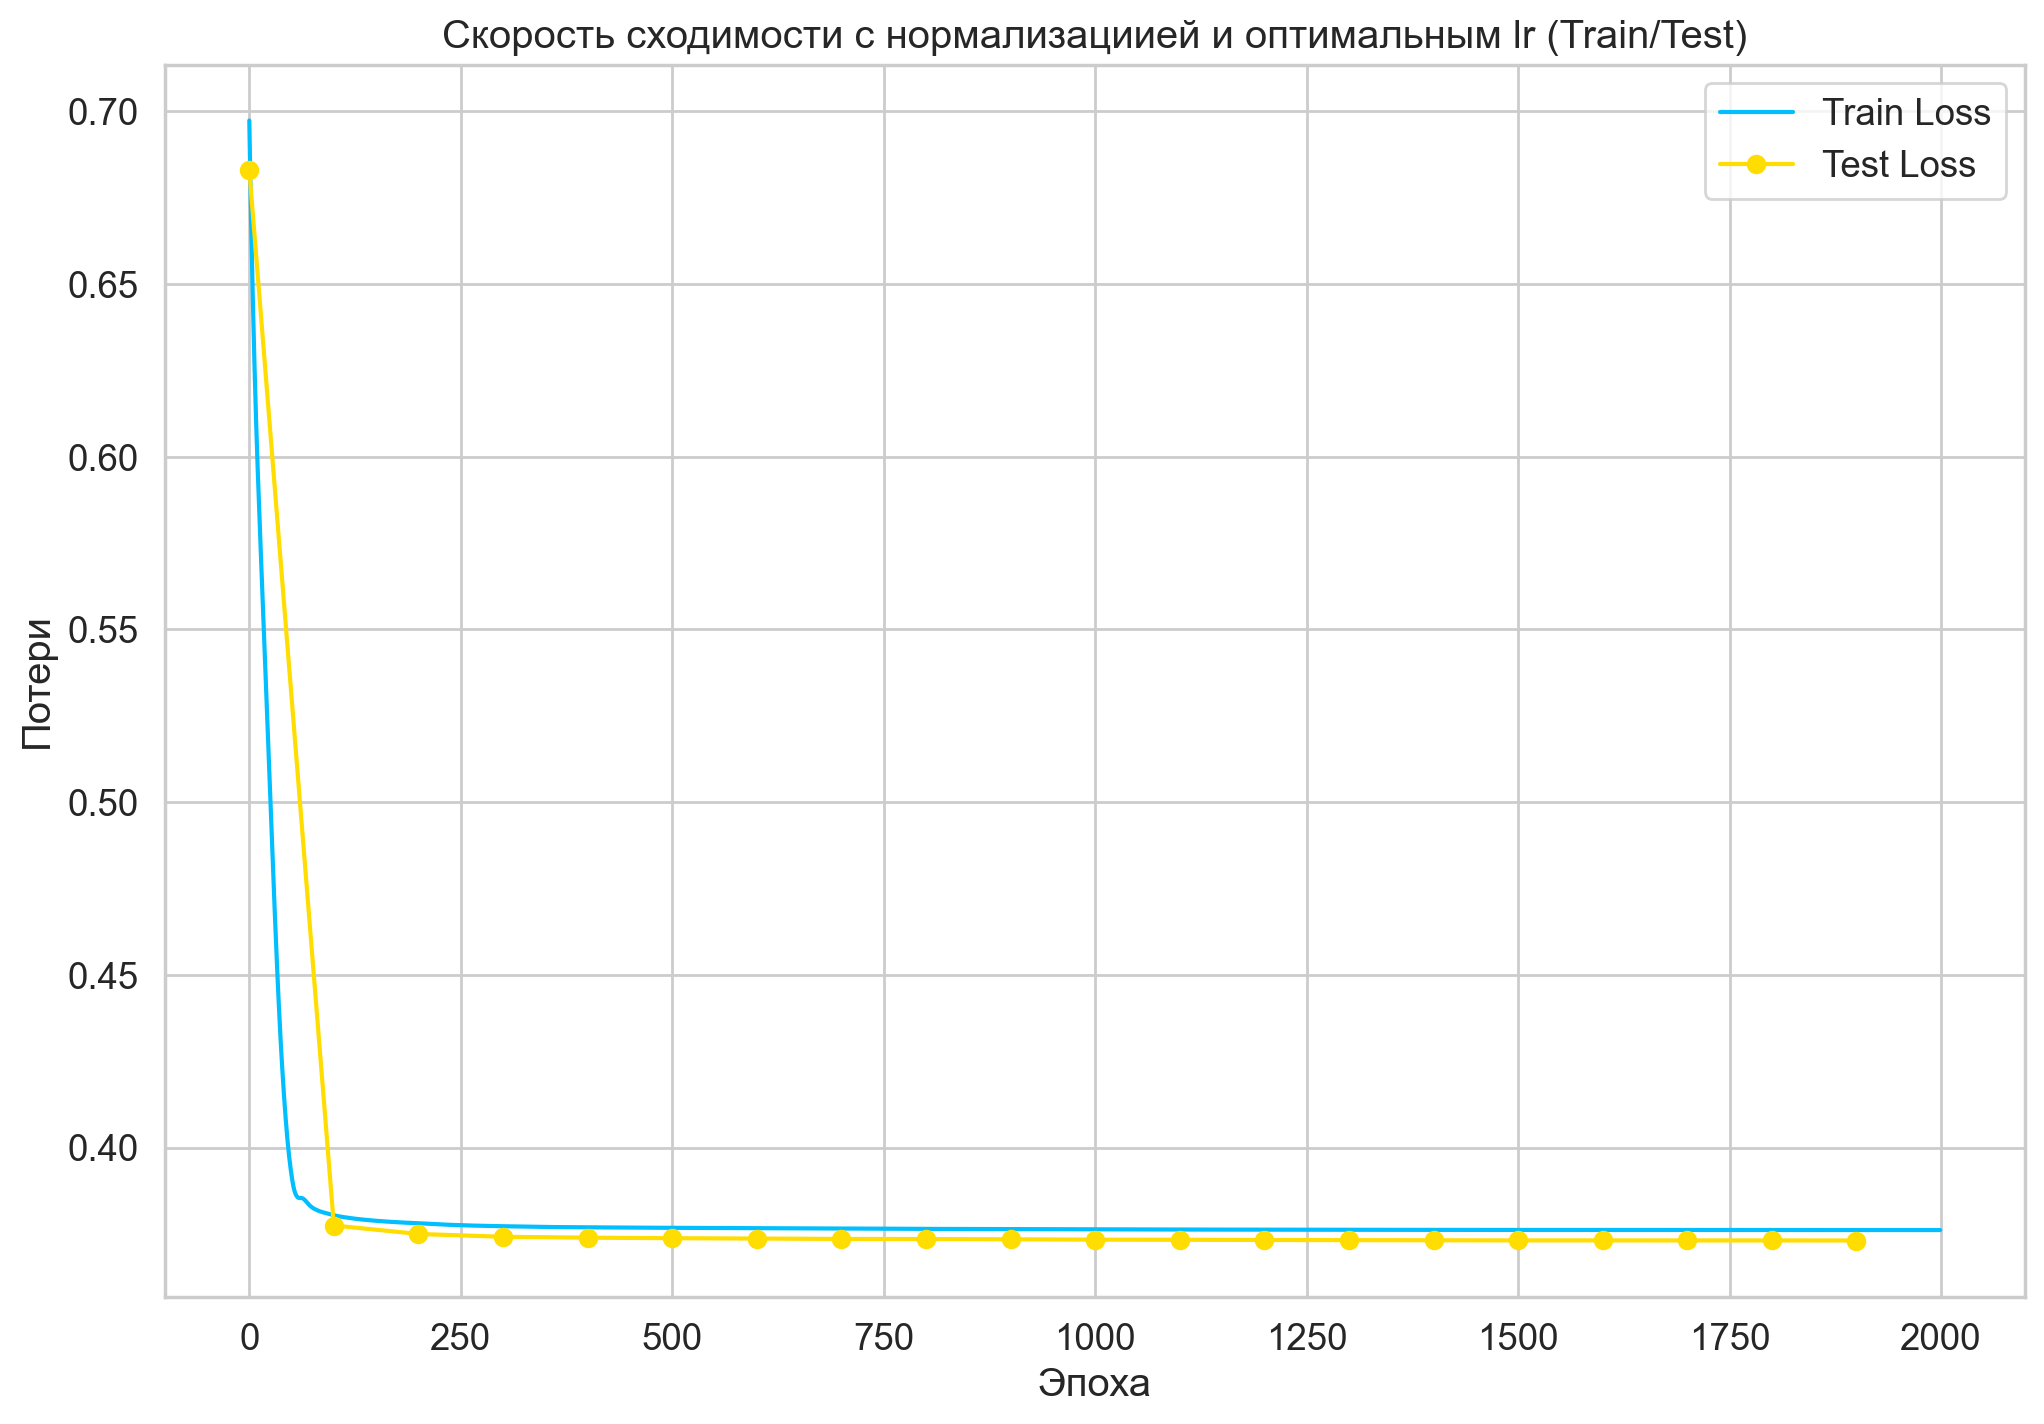

In [39]:
# 2. Примените нормализацию данных. Исследуйте скорость сходимости.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

# обучение
train_losses, test_losses = train_and_evaluate(optimal_lr)

plt.plot(train_losses, label='Train Loss')
plt.plot(range(0, 2000, 100), test_losses, label='Test Loss', marker='o')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости с нормализациией и оптимальным lr (Train/Test)')
plt.legend()
plt.show()


Обучение с 0 скрытыми слоями и 2 нейронами в слое
Обучение с 1 скрытыми слоями и 4 нейронами в слое
Обучение с 2 скрытыми слоями и 8 нейронами в слое
Обучение с 3 скрытыми слоями и 16 нейронами в слое


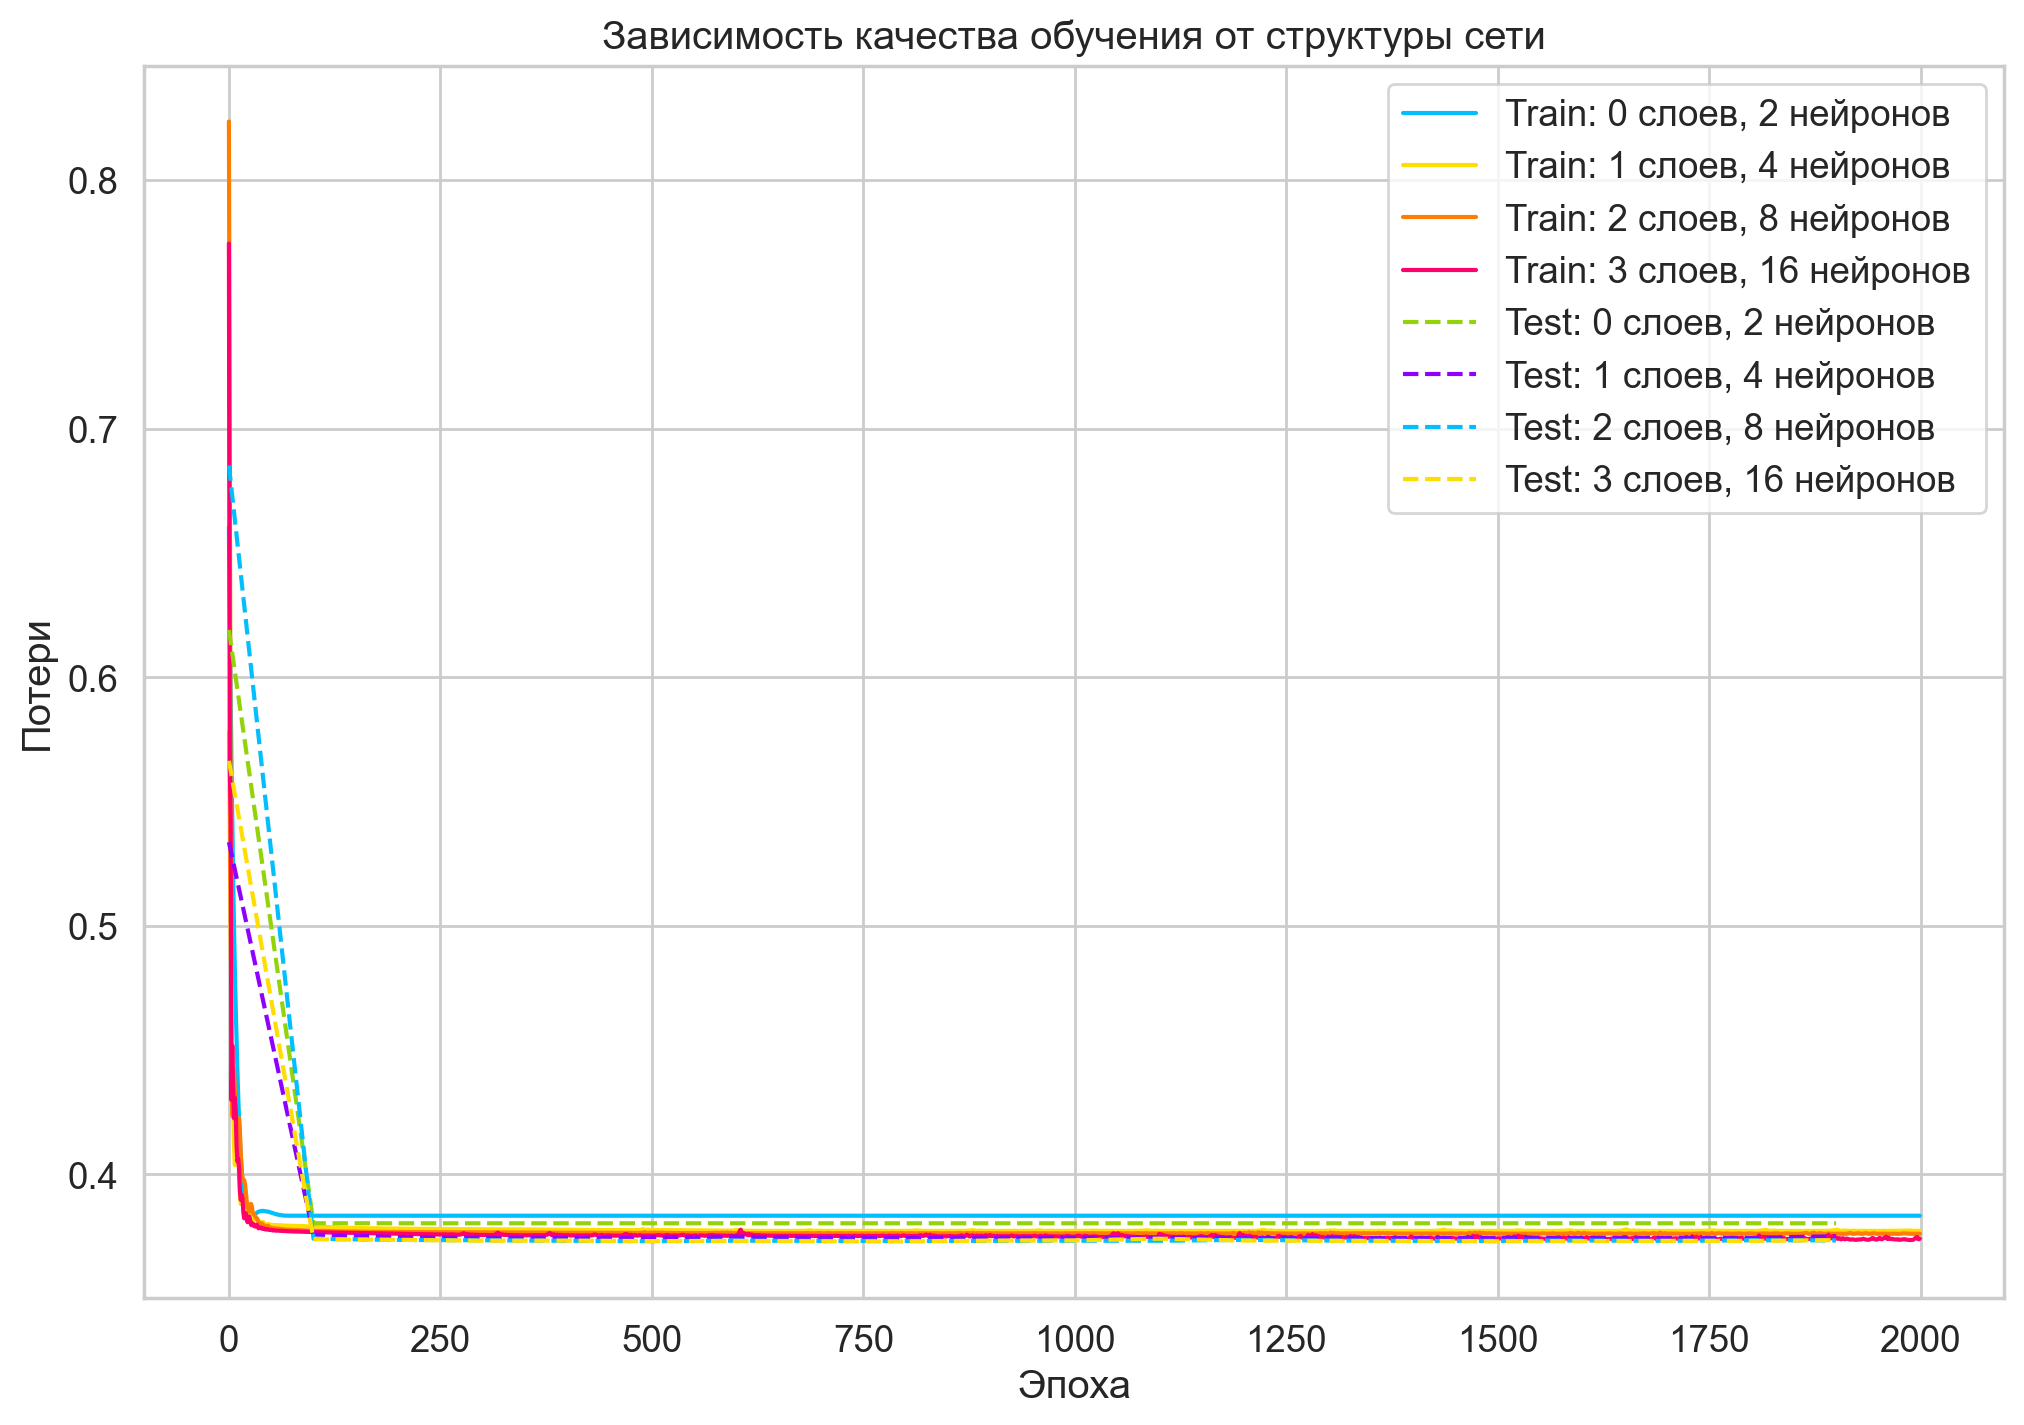

Конфигурация: 0 слоев, 2 нейронов -> Лучшее значение test_loss: 0.3803713619709015
Конфигурация: 1 слоев, 4 нейронов -> Лучшее значение test_loss: 0.3744519352912903
Конфигурация: 2 слоев, 8 нейронов -> Лучшее значение test_loss: 0.373182088136673
Конфигурация: 3 слоев, 16 нейронов -> Лучшее значение test_loss: 0.3730419874191284


In [61]:
# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.
# Изменим структуру сети, добавляя/удаляя слои и изменяя количество нейронов в слоях.
class MyNet(nn.Module):
    def __init__(self, n_features, n_neurons_per_layer, n_hidden_layers):
        super(MyNet, self).__init__()
        layers = []
        input_size = n_features

        # Добавление скрытых слоев
        for i in range(n_hidden_layers):
            layers.append(nn.Linear(input_size, n_neurons_per_layer))
            layers.append(nn.ReLU())
            input_size = n_neurons_per_layer

        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_and_evaluate_with_structure(n_neurons_per_layer, n_hidden_layers, learning_rate=0.1):
    net = MyNet(4, n_neurons_per_layer, n_hidden_layers)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())

        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

configurations = [
    (2, 0),
    (4, 1),
    (8, 2),
    (16, 3)
]

train_loss = {}
test_loss = {}

# Обучаем и собираем потери для каждой конфигурации
for n_neurons, n_layers in configurations:
    print(f'Обучение с {n_layers} скрытыми слоями и {n_neurons} нейронами в слое')
    train_losses, test_losses = train_and_evaluate_with_structure(n_neurons, n_layers)
    train_loss[(n_neurons, n_layers)] = train_losses
    test_loss[(n_neurons, n_layers)] = test_losses

for (n_neurons, n_layers), losses in train_loss.items():
    plt.plot(losses, label=f'Train: {n_layers} слоев, {n_neurons} нейронов')

for (n_neurons, n_layers), losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'Test: {n_layers} слоев, {n_neurons} нейронов', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Зависимость качества обучения от структуры сети')
plt.legend()
plt.show()

best_test_loss = {}

for (n_neurons, n_layers), losses in test_loss.items():
    best_loss = min(losses)
    best_test_loss[(n_neurons, n_layers)] = best_loss
    print(f"Конфигурация: {n_layers} слоев, {n_neurons} нейронов -> Лучшее значение test_loss: {best_loss}")


Обучение с функцией активации: ReLU
Обучение с функцией активации: Sigmoid
Обучение с функцией активации: Tanh
Обучение с функцией активации: LeakyReLU
Обучение с функцией активации: ELU


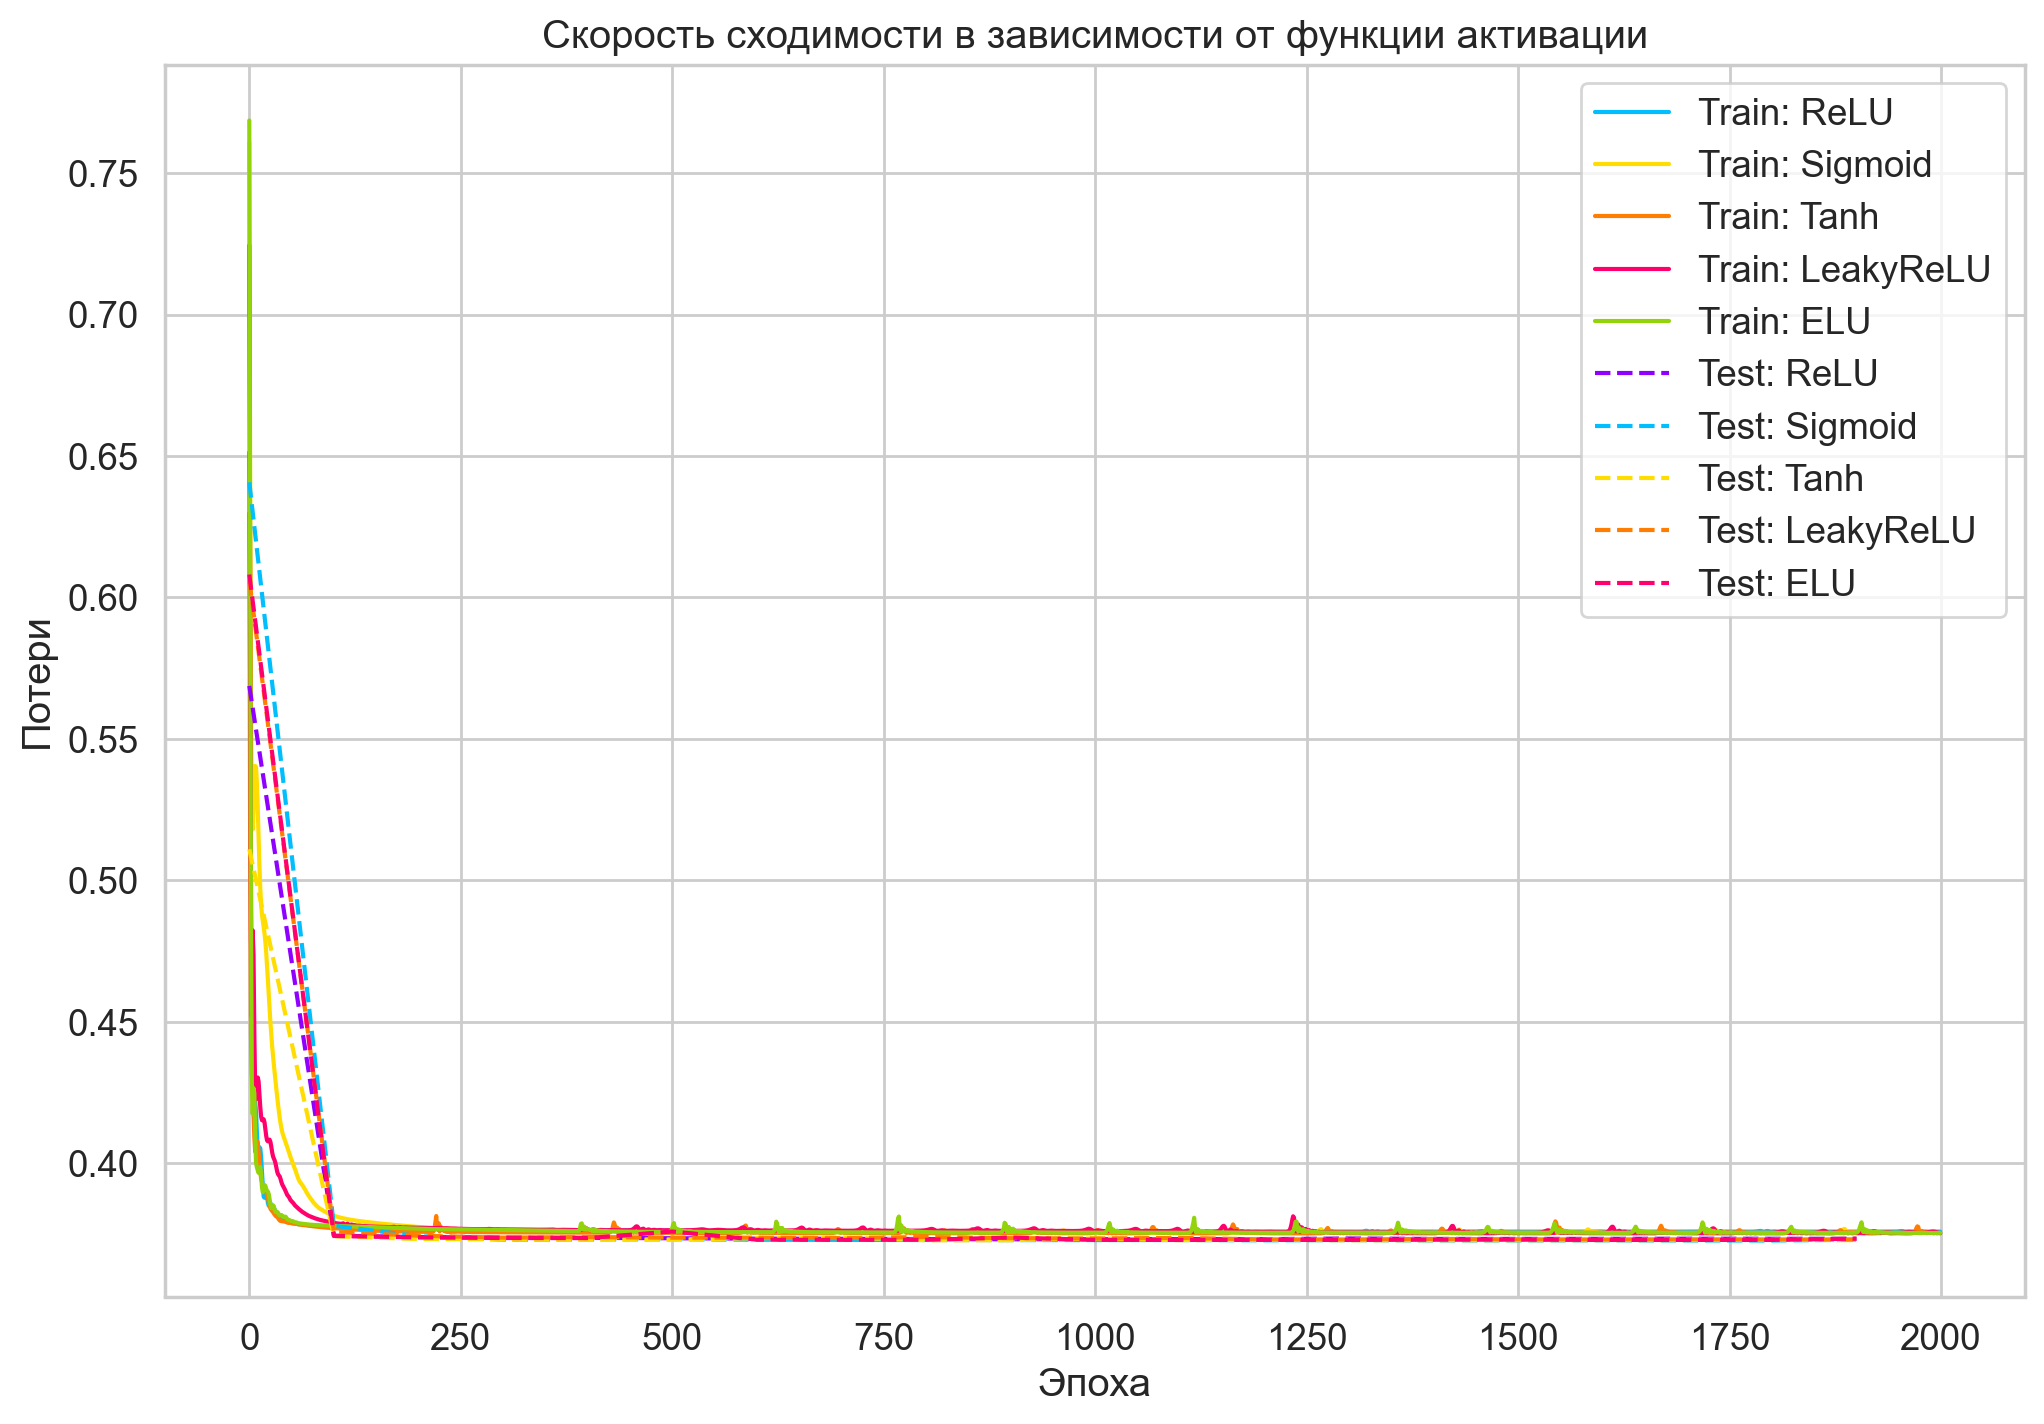

Функция активации: ReLU -> Лучшее значение test_loss: 0.3731466829776764
Функция активации: Sigmoid -> Лучшее значение test_loss: 0.37272971868515015
Функция активации: Tanh -> Лучшее значение test_loss: 0.37283584475517273
Функция активации: LeakyReLU -> Лучшее значение test_loss: 0.3730838894844055
Функция активации: ELU -> Лучшее значение test_loss: 0.37292298674583435


In [63]:
# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(0.01),
    'ELU': nn.ELU()
}

class MyNet(nn.Module):
    def __init__(self, n_features, activation_fn):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

def train_and_evaluate_with_activation(activation_fn):
    net = MyNet(4, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.1)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

train_loss = {}
test_loss = {}

for activation_name, activation_fn in activation_functions.items():
    print(f'Обучение с функцией активации: {activation_name}')
    train_losses, test_losses = train_and_evaluate_with_activation(activation_fn)
    train_loss[activation_name] = train_losses
    test_loss[activation_name] = test_losses

for activation_name, losses in train_loss.items():
    plt.plot(losses, label=f'Train: {activation_name}')

for activation_name, losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'Test: {activation_name}', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости в зависимости от функции активации')
plt.legend()
plt.show()

for activation_name in activation_functions:
    best_test_loss = min(test_loss[activation_name])
    print(f"Функция активации: {activation_name} -> Лучшее значение test_loss: {best_test_loss}")

Обучение с методом оптимизации: SGD
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
22.154943466186523
Обучение с методом оптимизации: Adam
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
16.362146377563477
Обучение с методом оптимизации: RMSprop
4.948537349700928
77.84505462646484
77.84505462646484
77.84505462646484
77.84505462646484
77.84505462646484
77.84505462646484
7

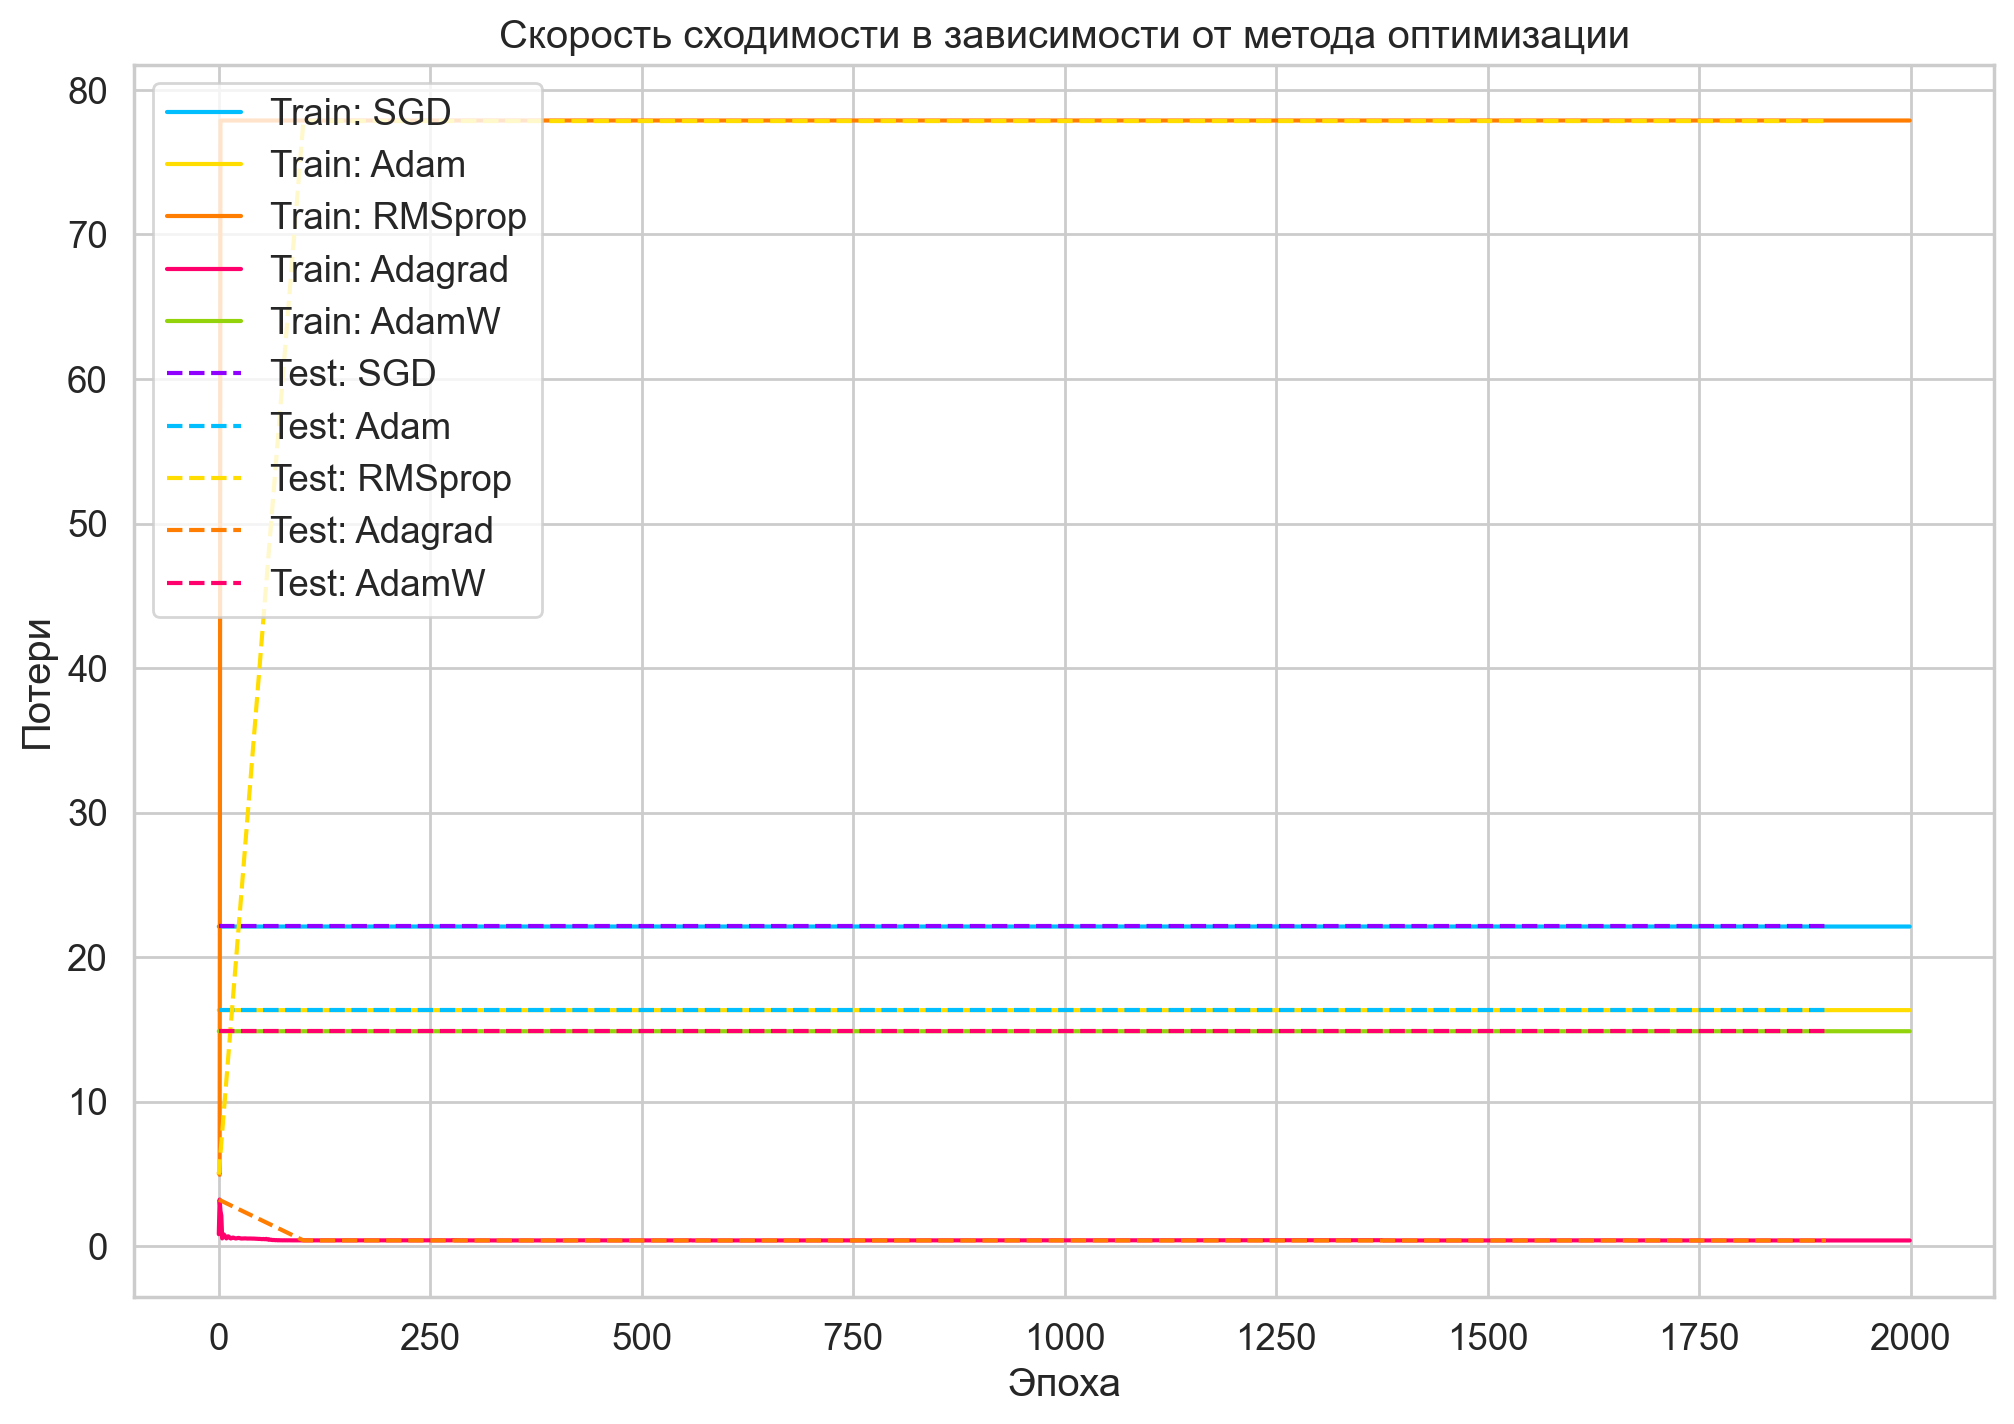

In [61]:
# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

class MyNet(nn.Module):
    def __init__(self, n_features, activation_fn):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

def train_and_evaluate_with_activation_optim(optimizer_name, activation_fn):
    net = MyNet(4, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.1)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

            print(test_loss.item())

    return train_losses, test_losses

train_loss = {}
test_loss = {}

optimizers = ['SGD', 'Adam', 'RMSprop', 'Adagrad', 'AdamW']

for optimizer_name in optimizers:
    print(f'Обучение с методом оптимизации: {optimizer_name}')
    train_losses, test_losses = train_and_evaluate_with_activation_optim(optimizer_name, nn.LeakyReLU())
    train_loss[optimizer_name] = train_losses
    test_loss[optimizer_name] = test_losses

for optimizer_name, losses in train_loss.items():
    plt.plot(losses, label=f'Train: {optimizer_name}')

for optimizer_name, losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'Test: {optimizer_name}', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости в зависимости от метода оптимизации')
plt.legend()
plt.show()


In [62]:
for optimizer_name in optimizers:
    best_test_loss = min(test_loss[optimizer_name])
    print(f"Метод оптимизации: {optimizer_name} -> Лучшее значение test_loss: {best_test_loss}")

Метод оптимизации: SGD -> Лучшее значение test_loss: 22.154943466186523
Метод оптимизации: Adam -> Лучшее значение test_loss: 16.362146377563477
Метод оптимизации: RMSprop -> Лучшее значение test_loss: 4.948537349700928
Метод оптимизации: Adagrad -> Лучшее значение test_loss: 0.39375585317611694
Метод оптимизации: AdamW -> Лучшее значение test_loss: 14.892925262451172


Обучение с инициализацией весов: random
Обучение с инициализацией весов: xavier
Обучение с инициализацией весов: he
Обучение с инициализацией весов: zero


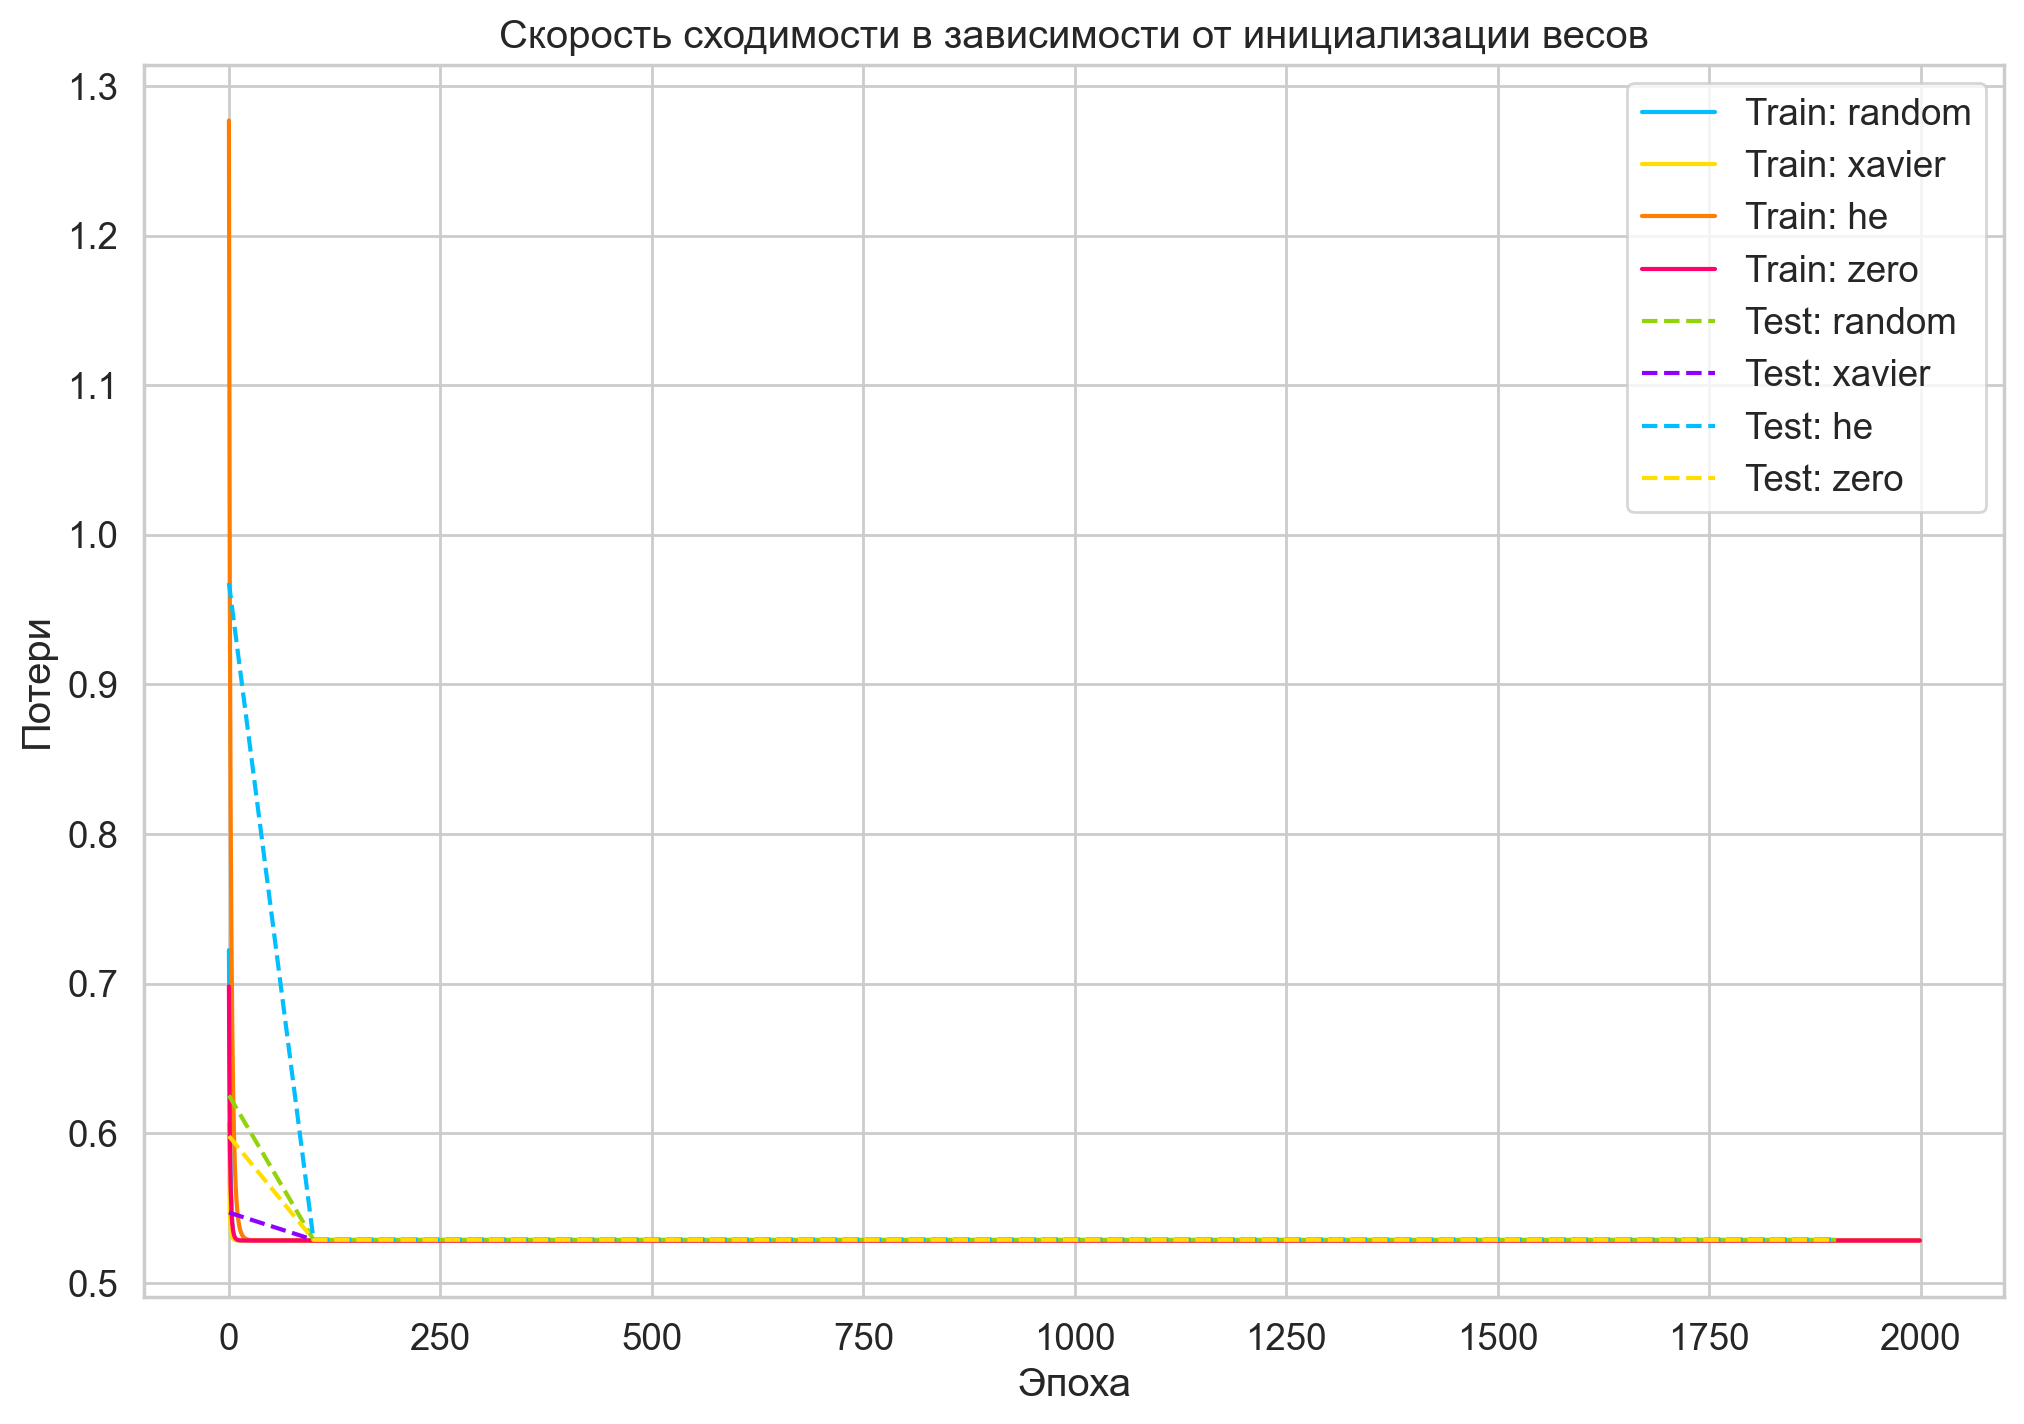

In [63]:
# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.
def initialize_weights(model, init_type):
    if init_type == 'default':
        pass
    elif init_type == 'xavier':
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    elif init_type == 'he':
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
    elif init_type == 'normal':
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.01)
                nn.init.zeros_(layer.bias)
    elif init_type == 'uniform':
        for layer in model.children():
            if isinstance(layer, nn.Linear):
                nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
                nn.init.zeros_(layer.bias)

def train_and_evaluate_with_weight_init(init_type):
    net = MyNet(4, nn.Sigmoid())
    initialize_weights(net, init_type)
    criterion = nn.BCELoss()
    optimizer = optim.Adagrad(net.parameters(), lr=0.1)

    train_losses = []
    test_losses = []

    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()

        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

train_loss = {}
test_loss = {}

initializations = ['random', 'xavier', 'he', 'zero']

for init_type in initializations:
    print(f'Обучение с инициализацией весов: {init_type}')
    train_losses, test_losses = train_and_evaluate_with_weight_init(init_type)
    train_loss[init_type] = train_losses
    test_loss[init_type] = test_losses

for init_type, losses in train_loss.items():
    plt.plot(losses, label=f'Train: {init_type}')

for init_type, losses in test_loss.items():
    plt.plot(range(0, 2000, 100), losses, label=f'Test: {init_type}', linestyle='--')

plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Скорость сходимости в зависимости от инициализации весов')
plt.legend()
plt.show()

In [65]:
for init_type in initializations:
    best_test_loss = min(test_loss[init_type])
    print(f"Метод инициализации: {init_type} -> Лучшее значение test_loss: {best_test_loss}")

Метод инициализации: random -> Лучшее значение test_loss: 0.5288624167442322
Метод инициализации: xavier -> Лучшее значение test_loss: 0.5288624167442322
Метод инициализации: he -> Лучшее значение test_loss: 0.5288624167442322
Метод инициализации: zero -> Лучшее значение test_loss: 0.5288624167442322
